In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale, minmax_scale
from sklearn import metrics

%matplotlib inline

# hockey = pd.read_pickle('/Users/marc/ds/metis/metisgh/hockey_filtered.csv') # Excluding NaNs
hockey = pd.read_pickle('/Users/marc/ds/metis/metisgh/hockey.csv') # All cleaned data INCL. NANs

In [17]:
hockey.birthCountry.replace('USSR','Russia',True)
hockey.rename(index=str, columns={'shootCatch': 'shoot'},inplace=True)

### 2013-2014 Players (for Eligibility)

In [18]:
Recent = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/NHLPlayers2013-14.csv')
allrecent = hockey[hockey.name.isin(Recent.Names)]
allrecent = allrecent[['playerID']]
allrecent['recent'] = 1
hockey = pd.merge(hockey,allrecent,how='outer')
hockey.recent.fillna(0,inplace=True)

### New HOF inductees since 2011 -- Holdout 

In [19]:
HOF2 = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF2.csv')
HOF2 = HOF2[HOF2.Year > 2011] ## Rogie Vachon & Dominik Hasek = Goalies
HOF2_names = HOF2.Name

In [20]:
new_HOF = hockey[hockey.name.isin(HOF2_names)].copy()
new_HOF['new_HOF'] = 1

hockey = pd.merge(hockey,new_HOF,how='outer')
hockey.new_HOF.fillna(0,inplace=True)

## HOF-Eligible Players

In [21]:
HOFtable = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF.csv')
HOFtable['playerID'] = [x[:-1] for x in HOFtable['hofID']]
HOFtable = HOFtable[HOFtable.category=='Player']
HOFtable = HOFtable[['playerID','year']]
HOFtable.columns = ['playerID','HOFyear']
HOFdelay = pd.merge(hockey[hockey.HOF==1],HOFtable,how='inner')

In [22]:
years = HOFdelay[['name','LastYear','HOFyear']].copy()
years['Delay'] = HOFdelay.HOFyear - HOFdelay.LastYear
years.sort_values('Delay',ascending=False).head(10);

In [23]:
all_retired = hockey[(hockey.recent == 0) & (hockey.new_HOF == 0)]
all_recent = hockey[(hockey.recent == 1) & (hockey.new_HOF == 0)] ## not needed

df = hockey[hockey.recent == 0]

# cutoff = 2017-20
# elig = hockey[(hockey.HOF == 0) & (hockey.recent == 0) & (hockey.LastYear >= cutoff)]

In [24]:
ret_nHOF = all_retired.HOF.value_counts()[0] # Retired Non-HOF
print('Retired Non-HOF Count:',ret_nHOF)
ret_HOF = all_retired.HOF.value_counts()[1] # Retired HOF
print('Retired \HOF Count:',ret_HOF)

# Baseline accuracy
noHOF_pred = ret_nHOF/(ret_HOF+ret_nHOF)
noHOF_pred

Retired Non-HOF Count: 5719
Retired \HOF Count: 182


0.96915776986951363

In [25]:
df.columns

Index(['playerID', 'name', 'true_pos', 'shoot', 'birthCountry', 'birthState',
       'birthCity', 'birthYear', 'GP', 'G', 'A', 'Pts', 'PIM', 'plus_min',
       'PPG', 'PPA', 'SHG', 'SHA', 'GWG', 'GTG', 'SOG', 'logGP',
       'logCareer_Years', 'award_count', 'series_wins', 'won_cup', 'team_pct',
       'country_pct', 'G_rank', 'A_rank', 'Pts_rank', 'Plusmin_rank',
       'SOG_rank', 'G_rank_T', 'A_rank_T', 'Pts_rank_T', 'Plusmin_rank_T',
       'SOG_rank_T', 'height', 'weight', 'FirstYear', 'LastYear',
       'Career_Years', 'HOF', 'recent', 'new_HOF'],
      dtype='object')

In [30]:
df = df[(df.award_count > 0) & (df.won_cup > 0) & (df.Pts > 0)]
df['log_awards'] = np.log(df.award_count)
df['log_cups'] = np.log(df.won_cup)
df['log_Pts'] = np.log(df.Pts)

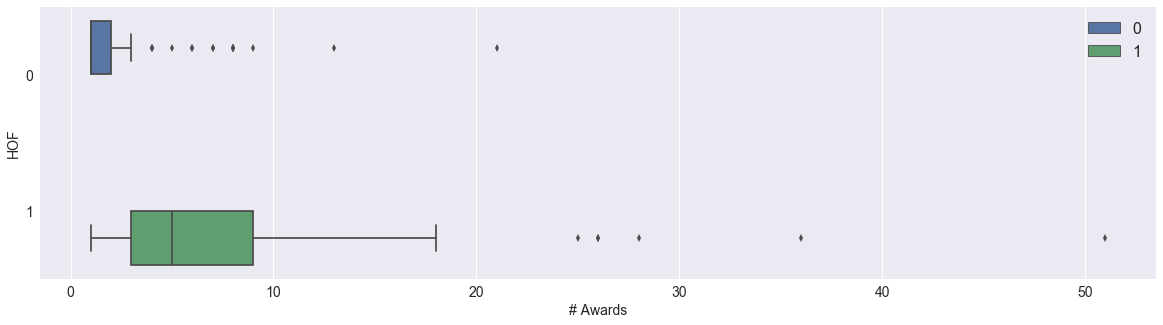

In [77]:
plt.figure(figsize=(20,5))
sns.boxplot(x="award_count", y="HOF", hue="HOF", data=df,orient="h")
plt.ylabel('HOF',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('# Awards',fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16);

In [95]:
def plot_distribution( df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df , hue=target, aspect=4, row=row, col=col,)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(df[var].min() , df[var].max()))
    facet.add_legend()


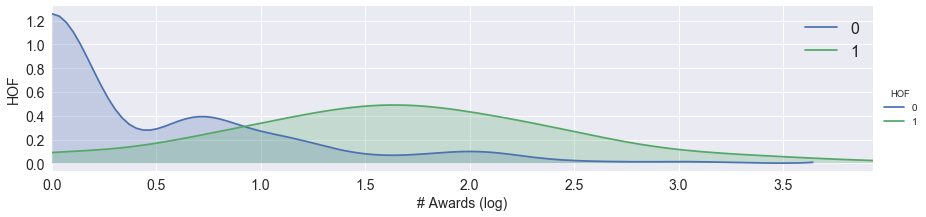

In [96]:
hof_awards = df[df.HOF==1].award_count
nhof_awards = df[df.HOF==0].award_count

features_to_plot = ['log_awards'] #,'won_cup','Pts','log_awards','log_cups','log_Pts'
for feature in features_to_plot:
    plt.figure(figsize=(20,5));
    plot_distribution(df, feature, 'HOF')
    plt.ylabel('HOF',fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('# Awards (log)',fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=16);

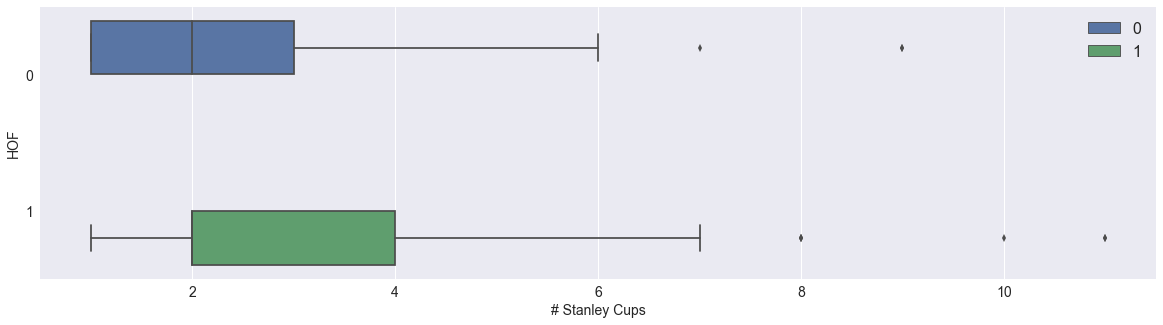

In [101]:
plt.figure(figsize=(20,5))
sns.boxplot(x="won_cup", y="HOF", hue="HOF", data=df,orient="h")
plt.ylabel('HOF',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('# Stanley Cups',fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16);

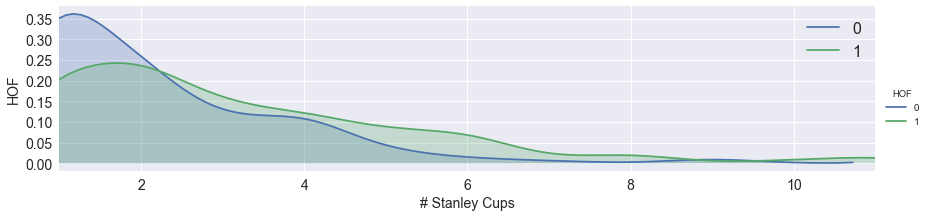

In [97]:
features_to_plot = ['won_cup'] #,'won_cup','Pts','log_awards','log_cups','log_Pts'
for feature in features_to_plot:
    plt.figure(figsize=(15,5));
    plot_distribution(df, feature, 'HOF')
    plt.ylabel('HOF',fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('# Stanley Cups',fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=16);

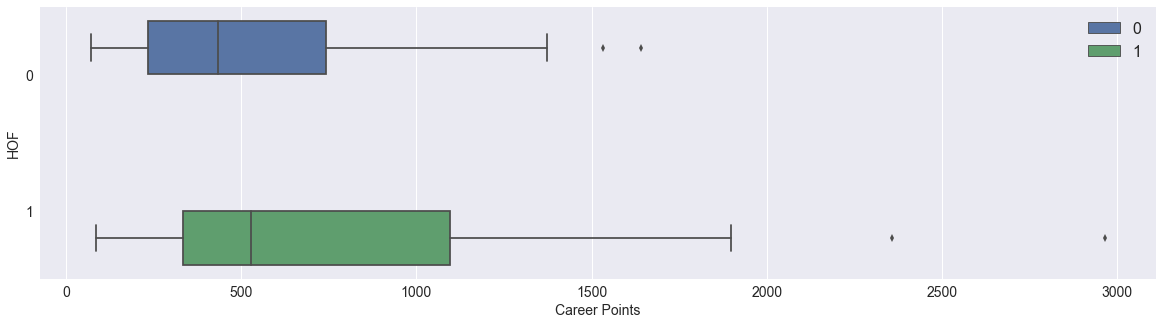

In [99]:
plt.figure(figsize=(20,5))
sns.boxplot(x="Pts", y="HOF", hue="HOF", data=df,orient="h")
plt.ylabel('HOF',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Career Points',fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16);

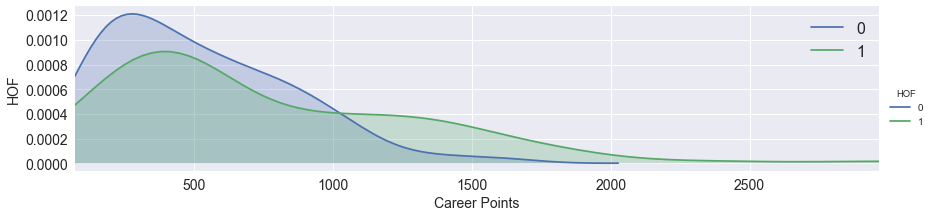

In [100]:
features_to_plot = ['Pts'] #,'won_cup','Pts','log_awards','log_cups','log_Pts'
for feature in features_to_plot:
    plt.figure(figsize=(15,5));
    plot_distribution(df, feature, 'HOF')
    plt.ylabel('HOF',fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Career Points',fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=16);